In [1]:
#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statsmodels.formula.api as smf
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import het_breuschpagan #Heteroskedasticity test
from statsmodels.stats.diagnostic import het_white #Heteroskedasticity test
from sklearn.metrics import confusion_matrix
from linearmodels import IV2SLS

#Probabilistic programs
#!pip install numpy mkl #if you are in an intel machine i.e. in mac M# chips no
#!pip install pymc
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
from pymc import do, observe
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs 
#IMPORTANT: properly install ipywidgets and nodejs for interactive graphs
#If you are in jupyterlab, activate the widget extension (it should be in the latest versions)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
import matplotlib.ticker as plticker
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from mpl_toolkits.mplot3d import axes3d
import arviz as az



#Misc
#!pip install stargazer
from stargazer.stargazer import Stargazer #I also have the .py in the folder (in case it fails to install or run)



WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.17.0


# Biased estimations without causal structure

## Gender discrimination at Google
(source: Mixtape text book by Cunningham)

In [5]:
tb = pd.DataFrame({
    'female': np.random.binomial(1, .5, size=10000),
    'ability': np.random.normal(size=10000)})
tb['discrimination'] = tb.female.copy()
tb['occupation'] = 1 + 2*tb['ability'] + 0*tb['female'] - 2*tb['discrimination'] + np.random.normal(size=10000)
tb['wage'] = 1 - 1*tb['discrimination'] + 1*tb['occupation'] + 2*tb['ability'] + np.random.normal(size=10000) 



lm_1 = sm.OLS.from_formula('wage ~ female', data=tb).fit()
lm_2 = sm.OLS.from_formula('wage ~ female + occupation', data=tb).fit()
lm_3 = sm.OLS.from_formula('wage ~ female + occupation + ability', data=tb).fit()


st = Stargazer((lm_1,lm_2,lm_3))
st.custom_columns(["Biased Unconditional", "Biased", "Unbiased Conditional"], [1, 1, 1])
st

# Causal Structures

Textbooks by Matheus Facure Alves:

* Causal Inference for The Brave and True. https://matheusfacure.github.io/python-causality-handbook/landing-page.html

* Causal Inference in Python: Applying Causal Inference in the Tech Industry https://github.com/matheusfacure/causal-inference-in-python-code/tree/main 

## Structure 1: Instrumental Variable

Bank: prime credit card to its customers. 

Question: how much the prime card increases customers’ purchase volume (PV).

Instrument:  Prime credit card (prime_eligible) to 10,000 customers. 50% chance of being eligible and 50% of being in the control. The bank can’t force customers to choose the card, making this an experiment with non-compliance.

Data: customer’s age, income, and credit score. Purchase volume (pv) True effect of the prime card on pv (tau). Group a customer belongs to (prime_elegible). Acceptance of prime card (prime_card). Compliance category (categ).

In [6]:
df = pd.read_csv("prime_card.csv")
df.head()

,age,income,credit_score,prime_elegible,prime_card,pv,tau,categ
0,37.7,9687.0,822.0,0,0,4913.79,700.0,complier
1,46.0,13731.0,190.0,0,0,5637.66,200.0,never-taker
2,43.1,2839.0,214.0,1,1,2410.45,700.0,complier
3,36.0,1206.0,318.0,1,1,1363.06,700.0,complier
4,39.7,4095.0,430.0,0,0,2189.80,700.0,complier


In [7]:
# Let's do a simple OLS and interpret the coef for prime_card
m = smf.ols("pv~prime_card", data=df).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2534.4947,19.239,131.740,0.000,2496.783,2572.206
prime_card,588.1388,41.676,14.112,0.000,506.446,669.831


Is prime_card endogenous? Yes. Compliance is not imposed, costumers accepted or not i.e. self selection bias. Those who accepted may also a priori had higher purchase volume (pv).

Two stage least squares logic (2SLS)

<img src="img/IV_11.png" width="400"/>

In [9]:
#2SLS regression. 
formula = 'pv ~ 1 + [prime_card ~ prime_elegible]' #put inside square brackets the first stage
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="robust")
print(iv_model.summary.tables[0])
print(iv_model.summary.tables[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:                     pv   R-squared:                      0.0179
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0178
No. Observations:               10000   F-statistic:                    88.548
Date:                Fri, Oct 18 2024   P-value (F-stat)                0.0000
Time:                        08:29:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      2498.4     23.955     104.29     0.0000      2451.4      2545.3
prime_card     757.70     80.521     9.4100     0.00

There are 3 requisites for a good instrument:

1) Relevance: The instrumental variable must be strongly correlated with the endogenous explanatory variable(s). This means that the instrument should explain a significant portion of the variation in the endogenous variable, helping to mitigate the bias from endogeneity. In practice, this is often tested using the F-statistic in the first stage of two-stage least squares (2SLS).

2) Exogeneity: The instrument must be uncorrelated with the error term in the structural equation. This ensures that the instrument only affects the dependent variable through the endogenous explanatory variable and not directly, preventing omitted variable bias or reverse causality from contaminating the results.

3) Exclusion Restriction: The instrument should affect the dependent variable only through its influence on the endogenous explanatory variable and not through any other channel. This assumption is critical for isolating the causal effect of the explanatory variable on the dependent variable.


Let's check if prime_eligible is a good instrument with these 3 requisites.

What happened to the coef for prime_card? Is it larger or smaller? If the instrument is good, we should trust the new coef.

In [10]:
# Additional controls (outside square brackets) and instruments (inside square brackets)
formula = '''pv ~ 1 
+ [prime_card ~ prime_elegible + credit_score]
+ income + age'''
iv_model = IV2SLS.from_formula(formula, df).fit(cov_type="robust")
print(iv_model.summary.tables[0])
print(iv_model.summary.tables[1])

                          IV-2SLS Estimation Summary                          
Dep. Variable:                     pv   R-squared:                      0.9581
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9581
No. Observations:               10000   F-statistic:                 2.238e+05
Date:                Fri, Oct 18 2024   P-value (F-stat)                0.0000
Time:                        08:34:09   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      210.62     37.615     5.5992     0.0000      136.89      284.34
income         0.3998     0.0009     469.77     0.00

## Structure 2: Confounder

https://www.patreon.com/posts/98613437

https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/

https://causalpy.readthedocs.io/

For synergies, the marketing area of the bank decided to only activate google ads when tv ads are on. They created, inadvertently, a confounder. 
<div align="center">
  <img src="img/Bayes_Causal_2.png" width="500"/>
</div>

Assuming this is the correct causal structure, $\theta_1$ measures the causal effect of $Google_{ads}$ on sales

Let's build this generative model with PyMC

In [2]:
#First load some data.
#This is simulated data for pedagogical purposes
#The data respects the DAG above (see appendix).
#Let's see if we can recuperate the paths
df_marketing = pd.read_csv("Causal_Marketing.csv", usecols = lambda column: column != 'Unnamed: 0') 
df_marketing

,Sales,Google_Ads,Tv_Ads
0,0.112651,1,-0.299913
1,1.956038,1,1.088218
2,0.377104,0,-0.072353
3,1.101803,1,0.457618
4,-1.667207,0,0.153005
...,...,...,...
1995,-1.761179,1,-0.488734
1996,-5.652544,0,-1.258181
1997,-0.888011,0,-0.036651
1998,2.228618,0,0.374342


C:\Users\L03552670\anaconda3\envs\PyMC_env\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\L03552670\anaconda3\envs\PyMC_env\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


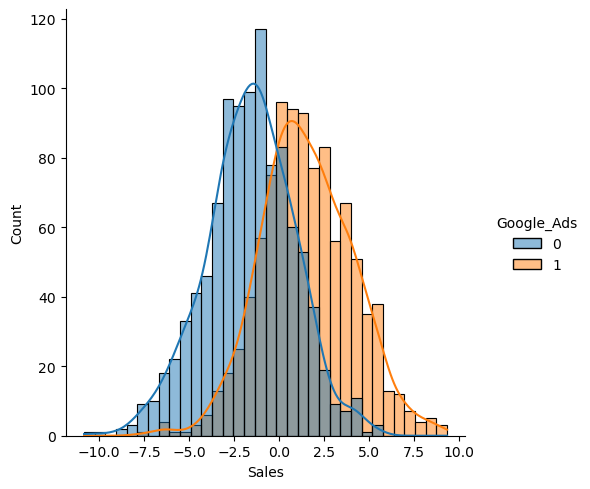

In [3]:
ax = sns.displot(data=df_marketing, x="Sales", hue="Google_Ads", kde=True)
ax.set(xlabel="Sales");

Google Ads has a positive influence on sales (the "1" histogram shifted to the right). However, we know there is no underlying causal effect between them (see appendix, $\theta_1$ is a mu=0, sigma = 1). The difference is driven by the TV confounder.

In [4]:
with pm.Model() as model_inferential: 
    # priors on sales <- tv_ads -> google_ads
    theta_0 = pm.Normal("theta_0", mu=0, sigma=10) #sales baseline 
    theta_2 = pm.Normal("theta_2", mu=0, sigma=10) #effect of tv ads on sales
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10) #effect of tv ads on google ads
    
    # priors on google ads -> sales causal path
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10) #Base level of google ads
    theta_1 = pm.Normal("theta_1", mu=0, sigma=10) # effect of google ads on sales

    #Prior on mean of tv_ads
    mu_tv_ads = pm.Normal("mu_tv_ads", mu=0, sigma=10) 


    #Likelihoods
    tv_ads = pm.Normal("tv_ads", mu = mu_tv_ads, sigma = df_marketing["Tv_Ads"].std(), observed = df_marketing["Tv_Ads"]) 
    google_ads = pm.Bernoulli("google_ads", p = pm.invlogit(beta_0 + beta_1 * df_marketing["Tv_Ads"]), observed = df_marketing["Google_Ads"])
    sales_mu =  theta_0 + (theta_1 * df_marketing["Google_Ads"]) + (theta_2 * df_marketing["Tv_Ads"])
    sales = pm.Normal("sales", mu=sales_mu, sigma=df_marketing["Sales"].std(), observed = df_marketing["Sales"])

    #Sample posterior
    trace = pm.sample(1000,                   # Samples per chain
                      tune=500,               # Tuning steps
                      chains=4,               # Number of chains
                      target_accept=0.8,      # Adjust target acceptance rate 
                      idata_kwargs={"log_likelihood": True}
                     ) 
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_0, theta_2, beta_1, beta_0, theta_1, mu_tv_ads]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 110 seconds.


In [5]:
summary = az.summary(trace)
summary #All rhat should be small, say less than 1.05

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-0.062,0.059,-0.169,0.051,0.001,0.001,5241.0,2826.0,1.00
beta_1,2.226,0.098,2.038,2.413,0.001,0.001,5284.0,2910.0,1.00
mu_tv_ads,-0.011,0.022,-0.051,0.030,0.000,0.000,5005.0,3222.0,1.01
theta_0,-0.041,0.106,-0.226,0.168,0.002,0.001,3018.0,3402.0,1.00
theta_1,-0.024,0.170,-0.356,0.283,0.003,0.002,2843.0,3134.0,1.00
theta_2,2.498,0.086,2.339,2.667,0.001,0.001,3451.0,3164.0,1.00


Note how the model does a good job at retrieving the latent parameters (compare mean column of the summary with the data generating process in Appendix).

Let's plot $\theta_1$, the parameter representing the effect of Google ads on sales

Mean effect of google ads on sales:  -0.023575823002626877

Prob. positive effect of google ads on sales:  0.439

Prob. zero effect of google ads on sales:  0.22225


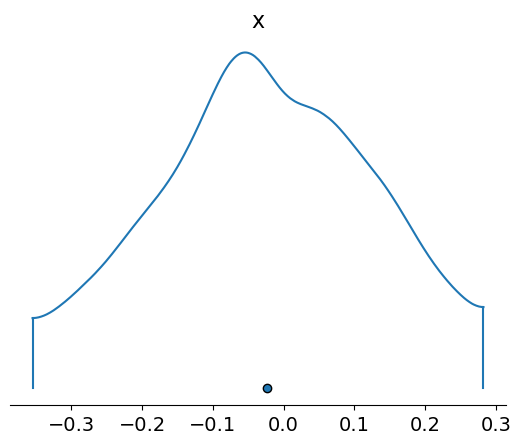

In [16]:
posterior = az.extract(trace) #.extract puts together all chains
effect_google_ads = np.array(posterior["theta_1"])
print("Mean effect of google ads on sales: ", effect_google_ads.mean())
print("\nProb. positive effect of google ads on sales: ", (effect_google_ads>0).mean())
print("\nProb. zero effect of google ads on sales: ", ((effect_google_ads>(-0.05)) & (effect_google_ads<0.05)).mean())
az.plot_density(effect_google_ads);


The inference places the mean effect close to zero (as it should, see appendix). If anything the probability that Google ads has a positive effect on sales is not stellar and there is a considerable probability of being zero, given our data and model.



# Appendix

## Data simulation Google ads

In [90]:
with pm.Model() as model_generative: 
    # priors on sales <- tv_ads -> google_ads
    theta_0 = pm.Normal("theta_0") #sales baseline mu=0,sigma=1 because they were z-scored for instance
    theta_2 = pm.Normal("theta_2", mu = 2.5, sigma = 0.05) #effect of tv ads on sales
    beta_1 = pm.Normal("beta_1", mu = 2.5, sigma = 0.05) #effect of tv ads on google ads
    # priors on google ads -> sales causal path
    beta_0 = pm.Normal("beta_0") #Base level of google ads
    theta_1 = pm.Normal("theta_1") # effect of google ads on sales

    #Noise of sales
    sigma_sales = pm.HalfNormal("sigma_sales")  # observation noise on sales

    #Nodes
    tv_ads = pm.Normal("tv_ads", mu=0, sigma=1) #mu=0,sigma=1 because they were z-scored for instance
    google_ads = pm.Bernoulli("google_ads", p = pm.invlogit(beta_0 + beta_1 * tv_ads))
    sales_mu = pm.Deterministic("sales_mu", theta_0 + (theta_1 * google_ads) + (theta_2 * tv_ads))
    sales = pm.Normal("sales", mu=sales_mu, sigma=sigma_sales)
    
    # Generate prior predictive samples
    prior_pred = pm.sample_prior_predictive(samples=2000)

   

Sampling: [beta_0, beta_1, google_ads, sales, sigma_sales, theta_0, theta_1, theta_2, tv_ads]


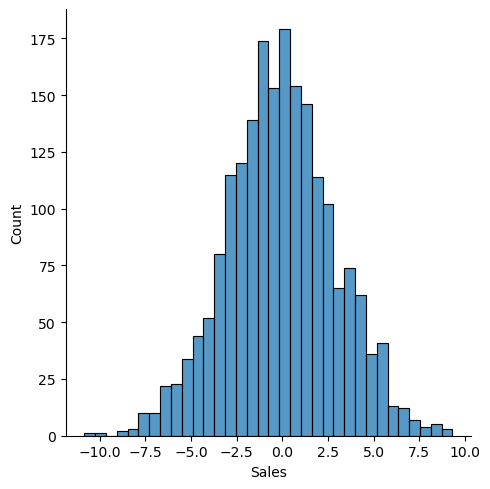

In [91]:
df = pd.DataFrame({
    'Sales': np.array(prior_pred.prior["sales"]).flatten(),
    'Google_Ads': np.array(prior_pred.prior["google_ads"]).flatten(),
    'Tv_Ads': np.array(prior_pred.prior["tv_ads"]).flatten()  
})

df.to_csv("Causal_Marketing.csv")
sns.displot(df, x = "Sales");
